In [1]:
import os, json, re
from typing import Dict
import torch
import torch.nn as nn
import pandas as pd

In [2]:
CSV_PATH = "./BooksDatasetClean.csv" # Do replace with your own path

In [3]:
df = pd.read_csv(CSV_PATH)
df = df.dropna(subset=['Description', 'Category'])

In [4]:
df

,Title,Authors,Description,Category,Publisher,Price Starting With ($),Publish Date (Month),Publish Date (Year)
7,Journey Through Heartsongs,"By Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,"Poetry , General",VSP Books,19.96,September,2001
8,In Search of Melancholy Baby,"By Aksyonov, Vassily, Heim, Michael Henry, and...",The Russian author offers an affectionate chro...,"Biography & Autobiography , General",Random House,4.99,June,1987
10,The Dieter's Guide to Weight Loss During Sex,"By Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",Workman Publishing Company,4.99,January,1978
11,Germs : Biological Weapons and America's Secre...,"By Miller, Judith, Engelberg, Stephen, and Bro...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",Simon & Schuster,4.99,October,2001
13,The Good Book: Reading the Bible with Mind and...,"By Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography , General",Harper Perennial,5.29,May,1998
...,...,...,...,...,...,...,...,...
103050,Like A Sister: A Novel,"By Daugharty, Janice",Sister cannot say exactly when or where she wa...,"Fiction , Literary",Harper,5.37,November,1999
103052,Creating Web Pages Simplified (3-D Visual Series),"By Maran, Ruth, Whitehead, Paul, and Marangrap...","An ""owner's manual"" for first-time Web page cr...","Computers , Internet , General",Hungry Minds Inc,5.95,January,1997
103053,EVA: The Real Key to Creating Wealth,"By Ehrbar, Al","Called ""today's hottest financial idea and get...","Business & Economics , Corporate Finance , Ge...",Wiley,29.96,October,1998
103056,The Essentials of Spanish (REA's Language Seri...,"By Mouat, Ricardo Gutierrez",REA’s Essentials provide quick and easy access...,"Foreign Language Study , Spanish",Research & Education Association,5.29,January,1998


## Preprocessing Book Descriptions

In [5]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_most_common_words(input_text) -> None:
  """ plots 20 of the most common words from `input_text`
  """

  tokens = " ".join(input_text).lower().split()
  word_counts = Counter(tokens)

  common_words = word_counts.most_common(20)
  words, counts = zip(*common_words)

  plt.bar(words, counts)
  plt.xticks(rotation=45)
  plt.title("20 Most Common Words")
  plt.show()

In [6]:
import numpy as np

def plot_vocab_coverage(input_text, coverage_threshold) -> None:
  """ plots the cumulative coverage of the vocabulary
  """

  tokens = " ".join(input_text).lower().split()
  word_counts = Counter(tokens)

  counts = np.array(sorted(word_counts.values(), reverse=True))
  total = counts.sum()
  cumulative_coverage = np.cumsum(counts) / total

  # Plot coverage
  plt.plot(cumulative_coverage)
  plt.xlabel("Vocabulary size")
  plt.ylabel("Cumulative coverage")
  plt.title("Vocab Coverage Curve")
  plt.grid(True)
  plt.show()

  vocab_size = np.argmax(cumulative_coverage >= coverage_threshold) + 1
  print(f"95% coverage achieved with vocab size: {vocab_size}")

As expected, the vocabulary is dominated by filler words like 'the', 'and', 'of', etc.

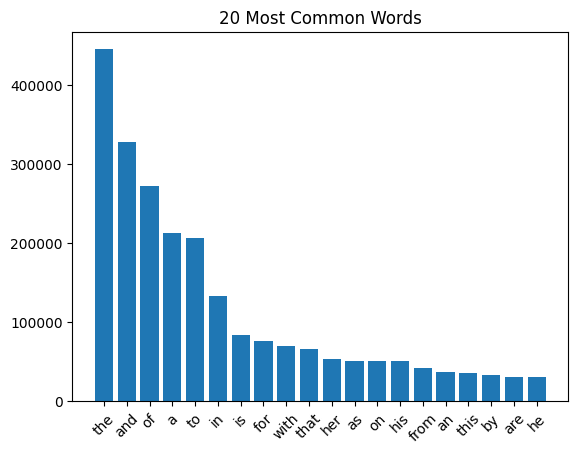

In [7]:
plot_most_common_words(df['Description'].to_list())

The preprocessing pipeline is condensed into the `preprocess_text` function. In chronological order, the steps we took to preprocess the movie plots are:  
* standardize all texts to lower case
* remove possibly existing html tags (i.e. '<>')
* remove punctuation but keep apostrophe
* remove stopwords but keep negation words like 'not', 'no' or 'nor' that might add to meaning
* lemmatization
* standardise spaces between the texts

In [8]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower().strip()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"[^\w\s']", '', text)

    tokens = text.split()

    # remove stopwords but keep negations like 'not', 'no', 'nor'
    filtered_tokens = [w for w in tokens if w not in stop_words or w in ['not', 'no', 'nor']]

    lemmatized = [lemmatizer.lemmatize(w) for w in filtered_tokens]

    return ' '.join(lemmatized)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/whiskeyone/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/whiskeyone/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
preprocessed_texts = [preprocess_text(p) for p in df['Description'].to_list()]

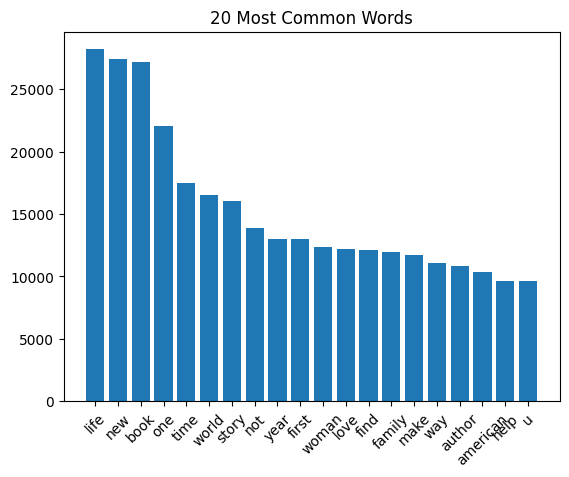

In [10]:
plot_most_common_words(preprocessed_texts)

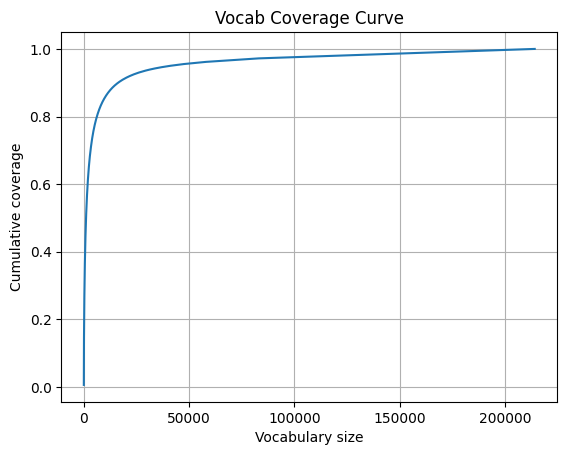

95% coverage achieved with vocab size: 40967


In [11]:
ideal_vocab_coverage = 0.95
plot_vocab_coverage(preprocessed_texts, ideal_vocab_coverage)

We build our own tokenizer with a maximum vocab size of 40971 (40967 + 4) consisting of:
* 40967 words from the 95% vocabulary coverage as shown in the cell above
* 4 special tokens `<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`, which are padding tokens, unknown words (out of vocabulary tokens), start of sentence, and end of sentence respectively.

In [12]:
BATCH_SIZE = 32
RANDOM_SEED = 42
VOCAB_SIZE = 40967
TEST_SPLIT = 0.15
VAL_SPLIT = 0.2 # note that this split is not absolute, it is relative to the training data that is already split by TEST_SPLIT

In [13]:
words = [w for t in preprocessed_texts for w in t.split()]

freqs = Counter(words)
vocab = ['<PAD>', '<UNK>', '<SOS>', '<EOS>'] + [w for w, _ in freqs.most_common(VOCAB_SIZE - 4)]
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}

def encode(t):
    tokens = t.split()
    return [stoi.get('<SOS>')] + [stoi.get(w, stoi['<UNK>']) for w in tokens] + [stoi.get('<EOS>')]

## Preprocessing Book Categories to Classify

In this step, we decide what the labels in the classification problem will be and how they are represented for the model to learn from.

In [14]:
print(df["Category"].value_counts())

Category
Fiction , General                                                            2274
Fiction , Literary                                                           1647
Fiction , Mystery & Detective , General                                      1555
Fiction , Thrillers , General                                                1105
Fiction , Thrillers , Suspense                                               1041
                                                                             ... 
Games & Activities , Travel Games                                               1
Travel , Cruises                                                                1
Mathematics , Mathematical Analysis                                             1
Transportation , Motorcycles , Pictorial                                        1
Young Adult Nonfiction , Biography & Autobiography , Science & Technology       1
Name: count, Length: 2983, dtype: int64


In [15]:
def split_category(text):
  """ splits the category into a list of strings
  """
  if not isinstance(text, str):
      return []
  parts = re.split(r'[,/|\s]+', text.lower())
  parts = [p.strip() for p in parts if p.strip()]
  return list(dict.fromkeys(parts))

In [16]:
def plot_category_freq_distribution(genre_counts):
  """ similar to plotting the most common words, but for categories. This time only the top 10 categories.
  """
  common_words = genre_counts.most_common(10)
  genre, counts = zip(*common_words)

  plt.bar(genre, counts)
  plt.xticks(rotation=45)
  plt.title("Top 10 Genre Frequency Distribution")
  plt.show()

In [17]:
category_list = []

for category_str in df["Category"]:
  category_list.append(split_category(category_str))

category_list = [[c for c in sublist if c != '&'] for sublist in category_list]

In [18]:
category_list[:10]

[['poetry', 'general'],
 ['biography', 'autobiography', 'general'],
 ['health', 'fitness', 'diet', 'nutrition', 'diets'],
 ['technology', 'engineering', 'military', 'science'],
 ['religion', 'biblical', 'biography', 'general'],
 ['biography', 'autobiography', 'personal', 'memoirs'],
 ['political', 'science', 'general'],
 ['pets', 'cats', 'general'],
 ['political', 'science', 'general'],
 ['fiction', 'general']]

Since the less popular categories will blow the total class number up making the classification problem very sparse, we collect the top 10 most common genres from the plot.

In [19]:
from collections import Counter

all_categories = [g for sublist in category_list for g in sublist]
category_counts = Counter(all_categories)

top_categories = [g for g, _ in category_counts.most_common(10)]
print(top_categories)

['general', 'fiction', 'juvenile', 'science', 'religion', 'romance', 'nonfiction', 'cooking', 'history', 'business']


If a movie only classifies in genres that are not in the top 10, we label its genre as 'other'.

In [20]:
category_list = [[g for g in sublist if g in top_categories] for sublist in category_list]

for i in range(len(category_list)):
  if len(category_list[i]) == 0:
    category_list[i] = ["other"]

**NOTE: The label frequency distribution is imbalanced. Something has to be done during training (e.g. using weight class during training)**

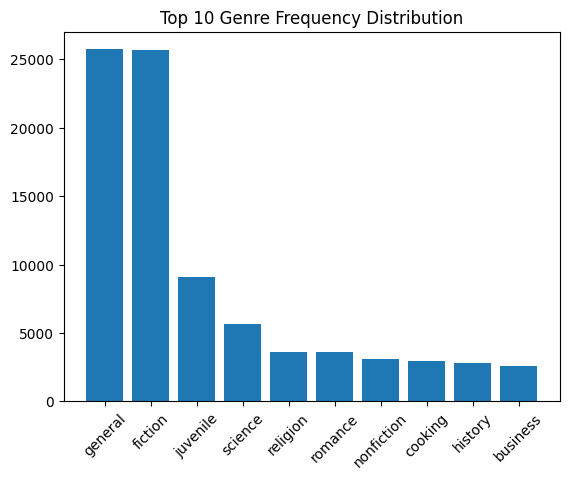

In [21]:
plot_category_freq_distribution(category_counts)

We encode the classes into a vector of length 11. Each index in the vector represents a category of the book to classify.

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(category_list)

print("All possible genres:", mlb.classes_)

All possible genres: ['business' 'cooking' 'fiction' 'general' 'history' 'juvenile'
 'nonfiction' 'other' 'religion' 'romance' 'science']


An example of a label's vector representation can be seen below.

In [23]:
print("Sample label: ", category_list[8])
print("The corresponding vector representation: ", y[8])

Sample label:  ['science', 'general']
The corresponding vector representation:  [0 0 0 1 0 0 0 0 0 0 1]


## Preparing the DataLoader

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class BookDataset(Dataset):
    def __init__(self, plots, labels):
        self.data = [torch.tensor(encode(p), dtype=torch.long) for p in plots]
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def collate_fn(batch):
    data, labels = zip(*batch)
    padded = pad_sequence(data, batch_first=True, padding_value=0)
    return padded, torch.stack(labels)

With the current train, val, test data split, the distribution of data samples will look consist of 15% test, 17% validation, 68% training data.

This is given that `TEST_SPLIT = 0.15` and `VAL_SPLIT = 0.2`.

In [25]:
from sklearn.model_selection import train_test_split

train_plots, test_plots, y_train, y_test = train_test_split(preprocessed_texts, y, test_size=TEST_SPLIT, random_state=RANDOM_SEED)
 # split training set again into train/val
train_plots, val_plots, y_train, y_val = train_test_split(train_plots, y_train, test_size=VAL_SPLIT, random_state=RANDOM_SEED)

train_ds = BookDataset(train_plots, y_train)
val_ds = BookDataset(val_plots, y_val)
test_ds = BookDataset(test_plots, y_test)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

## Inspecting the DataLoader

In [26]:
data_iter = iter(train_dl)
batch = next(data_iter)

inputs, labels = batch
print(inputs.shape)
print(labels.shape)

torch.Size([32, 205])
torch.Size([32, 11])


Each training batch has 32 samples (due to `BATCH_SIZE = 32`).

Each training input is of size 255 (in this specific batch sample) due to padding. Other batches may have different input lengths. We'll observe this in the next cell where the input length is now 236.

There are consistently 11 labels throughout training, i.e. the top 10 genres + `other`.

In [27]:
batch = next(data_iter)

inputs, labels = batch
print(inputs.shape)
print(labels.shape)

torch.Size([32, 196])
torch.Size([32, 11])


In [28]:
# Calculate the number of positive samples for each class in the training set
positive_counts = y_train.sum(axis=0)
total_samples = len(y_train)

# Calculate weights for the BCEWithLogitsLoss pos_weight argument
# Weight = Number of negative samples / Number of positive samples
class_weights = (total_samples - positive_counts) / positive_counts

# Convert to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = class_weights_tensor.to(device)

print("Class Weights:", class_weights_tensor)

Class Weights: tensor([24.2991, 20.9911,  1.5360,  1.5446, 22.5919,  6.1984, 20.2542,  3.7400,
        17.2341, 17.1744, 10.5987])


In [29]:
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        # We use the hidden state of the last time step as the sentence representation
        return self.fc(hidden[-1, :, :])


class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(hidden[-1, :, :])


class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.gru(embedded)
        return self.fc(hidden[-1, :, :])

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import time

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        total_train_loss = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # --- ADD GRADIENT CLIPPING HERE ---
            # This prevents the gradients from exploding.
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            total_train_loss += loss.item()

        # Validation phase (no changes needed here)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        end_time = time.time()

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {end_time-start_time:.2f}s')

        # Early stopping (no changes needed here)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
    return model


def evaluate_model(model, test_loader, model_name="Model"):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Convert logits to probabilities and then to binary predictions
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    print(f"\n=== Evaluating {model_name} on Test Set ===")
    print(f"Accuracy: {accuracy_score(all_labels, all_preds):.4f}")
    print(f"Precision (weighted): {precision_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
    print(f"Recall (weighted): {recall_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}")
    print(f"F1-Score (weighted): {f1_score(all_labels, all_preds, average='weighted', zero_division=0):.4f}\n")

    print(classification_report(all_labels, all_preds, target_names=mlb.classes_, zero_division=0))

In [31]:
# --- Hyperparameters ---
VOCAB_SIZE_MODEL = len(vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = len(mlb.classes_)
NUM_LAYERS = 2
DROPOUT = 0.5
LEARNING_RATE = 0.001  # <<< REDUCED LEARNING RATE
EPOCHS = 20
PATIENCE = 4

# --- Loss Function ---
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)

In [32]:
# --- 1. RNN Model ---
print("--- Starting RNN Training ---")
rnn_model = RNNClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)
trained_rnn = train_model(rnn_model, train_dl, val_dl, optimizer, criterion, epochs=EPOCHS, patience=PATIENCE)
evaluate_model(trained_rnn, test_dl, "RNN")


--- Starting RNN Training ---
Epoch 1/20 | Train Loss: 1.2241 | Val Loss: 1.2311 | Time: 117.25s
Epoch 2/20 | Train Loss: 1.2174 | Val Loss: 1.2328 | Time: 119.71s
Epoch 3/20 | Train Loss: 1.2168 | Val Loss: 1.2157 | Time: 114.91s
Epoch 4/20 | Train Loss: 1.2178 | Val Loss: 1.2219 | Time: 117.61s
Epoch 5/20 | Train Loss: 1.2180 | Val Loss: 1.2125 | Time: 114.25s
Epoch 6/20 | Train Loss: 1.2157 | Val Loss: 1.2256 | Time: 118.01s
Epoch 7/20 | Train Loss: 1.2177 | Val Loss: 1.2223 | Time: 118.76s
Epoch 8/20 | Train Loss: 1.2164 | Val Loss: 1.2304 | Time: 116.31s
Epoch 9/20 | Train Loss: 1.2175 | Val Loss: 1.2138 | Time: 116.50s
Early stopping triggered.

=== Evaluating RNN on Test Set ===
Accuracy: 0.0000
Precision (weighted): 0.2616
Recall (weighted): 0.6010
F1-Score (weighted): 0.3446

              precision    recall  f1-score   support

    business       0.00      0.00      0.00       386
     cooking       0.04      0.50      0.07       406
     fiction       0.39      0.77      0.

In [ ]:
# --- 2. LSTM Model ---
print("\n\n--- Starting LSTM Training ---")
lstm_model = LSTMClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
trained_lstm = train_model(lstm_model, train_dl, val_dl, optimizer, criterion, epochs=EPOCHS, patience=PATIENCE)
evaluate_model(trained_lstm, test_dl, "LSTM")



--- Starting LSTM Training ---
Epoch 1/20 | Train Loss: 1.1947 | Val Loss: 1.1999 | Time: 313.00s
Epoch 2/20 | Train Loss: 1.1897 | Val Loss: 1.1805 | Time: 307.73s
Epoch 3/20 | Train Loss: 1.1700 | Val Loss: 1.1589 | Time: 306.22s
Epoch 4/20 | Train Loss: 1.0884 | Val Loss: 0.9929 | Time: 306.83s
Epoch 5/20 | Train Loss: 0.9488 | Val Loss: 0.8874 | Time: 313.24s
Epoch 6/20 | Train Loss: 0.8371 | Val Loss: 0.7772 | Time: 317.68s
Epoch 7/20 | Train Loss: 0.7636 | Val Loss: 0.7344 | Time: 308.66s
Epoch 8/20 | Train Loss: 0.7177 | Val Loss: 0.7106 | Time: 312.10s


In [ ]:
# --- 3. GRU Model ---
print("\n\n--- Starting GRU Training ---")
gru_model = GRUClassifier(VOCAB_SIZE_MODEL, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, DROPOUT).to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)
trained_gru = train_model(gru_model, train_dl, val_dl, optimizer, criterion, epochs=EPOCHS, patience=PATIENCE)
evaluate_model(trained_gru, test_dl, "GRU")



--- Starting GRU Training ---
Epoch 1/20 | Train Loss: 1.1944 | Val Loss: 1.1997 | Time: 34.30s
Epoch 2/20 | Train Loss: 1.1931 | Val Loss: 1.1983 | Time: 34.18s
Epoch 3/20 | Train Loss: 0.9917 | Val Loss: 0.7584 | Time: 34.27s
Epoch 4/20 | Train Loss: 0.7004 | Val Loss: 0.6526 | Time: 34.60s
Epoch 5/20 | Train Loss: 0.6153 | Val Loss: 0.6094 | Time: 34.66s
Epoch 6/20 | Train Loss: 0.5704 | Val Loss: 0.5701 | Time: 34.27s
Epoch 7/20 | Train Loss: 0.5362 | Val Loss: 0.5867 | Time: 34.47s
Epoch 8/20 | Train Loss: 0.5099 | Val Loss: 0.5735 | Time: 34.67s
Epoch 9/20 | Train Loss: 0.4897 | Val Loss: 0.5571 | Time: 34.31s
Epoch 10/20 | Train Loss: 0.4700 | Val Loss: 0.5493 | Time: 34.56s
Epoch 11/20 | Train Loss: 0.4561 | Val Loss: 0.5742 | Time: 34.50s
Epoch 12/20 | Train Loss: 0.4415 | Val Loss: 0.5485 | Time: 34.25s
Epoch 13/20 | Train Loss: 0.4324 | Val Loss: 0.5428 | Time: 34.51s
Epoch 14/20 | Train Loss: 0.4182 | Val Loss: 0.5608 | Time: 34.52s
Epoch 15/20 | Train Loss: 0.4084 | Val 

In [ ]:
import os
save_path = './weights'
os.makedirs(save_path, exist_ok=True)

print(f"Weights will be saved to: {save_path}")

Weights will be saved to: /content/drive/MyDrive/Projects/EE6405_group_project/weights


In [ ]:
rnn_save_file = os.path.join(save_path, 'rnn_mod1_model_weights.pth')
torch.save(trained_rnn.state_dict(), rnn_save_file)
print(f"Saved trained RNN model weights to: {rnn_save_file}")

lstm_save_file = os.path.join(save_path, 'lstm_mod1_model_weights.pth')
torch.save(trained_lstm.state_dict(), lstm_save_file)
print(f"Saved trained LSTM model weights to: {lstm_save_file}")

gru_save_file = os.path.join(save_path, 'gru_mod1_model_weights.pth')
torch.save(trained_gru.state_dict(), gru_save_file)
print(f"Saved trained GRU model weights to: {gru_save_file}")

Saved trained RNN model weights to: /content/drive/MyDrive/Projects/EE6405_group_project/weights/rnn_mod1_model_weights.pth
Saved trained LSTM model weights to: /content/drive/MyDrive/Projects/EE6405_group_project/weights/lstm_mod1_model_weights.pth
Saved trained GRU model weights to: /content/drive/MyDrive/Projects/EE6405_group_project/weights/gru_mod1_model_weights.pth


In [ ]:
# Compute project root (this notebook is under <root>/Books/)
ROOT = os.path.dirname(os.getcwd())
DOMAIN = "books"
BUNDLE_DIR = os.path.join(ROOT, "artifacts", DOMAIN)
os.makedirs(BUNDLE_DIR, exist_ok=True)

# 1) labels.txt
labels = None
if 'mlb' in globals() and hasattr(mlb, 'classes_'):
    labels = list(mlb.classes_)
elif 'le' in globals() and hasattr(le, 'classes_'):
    labels = list(le.classes_)
elif 'classes' in globals():
    labels = list(classes)
if not labels or len(labels) < 2:
    raise RuntimeError("Could not determine labels. Ensure 'mlb'/'le'.classes_ or a 'classes' list exists.")
labels_path = os.path.join(BUNDLE_DIR, "labels.txt")
with open(labels_path, "w", encoding="utf-8") as f:
    for lab in labels:
        f.write(f"{lab}\n")
print(f"Wrote {labels_path} ({len(labels)} labels)")

# 2) preprocessor.json
word_index: Dict[str, int] = {}
if 'stoi' in globals() and isinstance(stoi, dict):
    word_index = {str(k): int(v) for k, v in stoi.items()}
elif 'word_index' in globals() and isinstance(word_index, dict):
    word_index = word_index
elif 'vocab' in globals() and isinstance(vocab, list):
    word_index = {str(w): int(i) for i, w in enumerate(vocab)}
else:
    raise RuntimeError("Could not determine word_index ('stoi', 'word_index', or 'vocab' required).")

max_length = 256
for key in ("MAX_SEQ_LEN", "MAX_LEN", "SEQ_LEN", "MAX_LENGTH"):
    if key in globals():
        try:
            max_length = int(globals()[key])
            break
        except Exception:
            pass
lowercase = True if 'LOWERCASE' not in globals() else bool(LOWERCASE)

padding_idx = 0
if '<PAD>' in word_index:
    padding_idx = int(word_index['<PAD>'])

oov_token_id = 1
if '<UNK>' in word_index:
    oov_token_id = int(word_index['<UNK>'])

preproc = {
    "word_index": word_index,
    "max_length": int(max_length),
    "lowercase": bool(lowercase),
    "oov_token_id": int(oov_token_id),
    "padding_idx": int(padding_idx),
    "tokenizer": "regex_basic",
}
preproc_path = os.path.join(BUNDLE_DIR, "preprocessor.json")
with open(preproc_path, "w", encoding="utf-8") as f:
    json.dump(preproc, f, ensure_ascii=False)
print(f"Wrote {preproc_path} (|word_index|={len(word_index)})")

# 3) model.ts (TorchScript)
# Try to locate a trained model in globals (prioritize LSTM/GRU/RNN)
_candidates = [
    'best_model',
    'trained_lstm', 'trained_gru', 'trained_rnn',
    'lstm_model', 'gru_model', 'rnn_model',
]
model_to_export = None
model_name = None
for name in _candidates:
    if name in globals() and isinstance(globals()[name], nn.Module):
        model_to_export = globals()[name]
        model_name = name
        break
if model_to_export is None:
    raise RuntimeError("No trained model found to export. Expected one of: " + ", ".join(_candidates))

model_to_export.eval()
# Prefer scripting; fallback to tracing with dummy LongTensor of length = max_length
try:
    scripted = torch.jit.script(model_to_export)
    export_mode = "scripted"
except Exception:
    dummy = torch.ones((1, int(max_length)), dtype=torch.long)
    scripted = torch.jit.trace(model_to_export, dummy, strict=False)
    export_mode = "traced"

# Write both a canonical model.ts and a named copy for reference
ts_canonical = os.path.join(BUNDLE_DIR, "model.ts")
scripted.save(ts_canonical)
print(f"Saved {export_mode} TorchScript to {ts_canonical}")

if model_name:
    ts_named = os.path.join(BUNDLE_DIR, f"{model_name}.ts")
    scripted.save(ts_named)
    print(f"Saved named TorchScript to {ts_named}")

